#  #Topics Covered:

    1>Decision Trees.
    2>Random Forests and Ensemble Methods.
    3>Gradient Boosting.
    4>Hyperparameter Tuning.
    5>Model Interpretability for Tree Models
# #Dataset: 'Adult Census Income' dataset.
# #Target: Predict whether income >50K.

# #importing lib. :
 pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score ,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Load Data
adult = fetch_openml(name='adult', version=2, as_frame=True)
X = adult.data
y = adult.target

# Preprocessing
# The target variable : "<=50K"--->0 & ">50K"--->1
le = LabelEncoder()
y = le.fit_transform(y) # >50K becomes 1 , <=50K becomes 0

# Identify columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create a preprocessing pipeline
# Trees handle unscaled data well, but we need to encode strings to numbers.
# We will use OneHotEncoding for categories and SimpleImputer for missing values.

numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on training data to transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Save feature names for later interpretation
feature_names = list(numerical_cols) + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))

print(f"Training shape: {X_train_processed.shape}")
print(f"Testing shape: {X_test_processed.shape}")

Training shape: (39073, 105)
Testing shape: (9769, 105)


# #Decision tree:

# #Gini Impurity vs Entropy:

# --Gini Impurity: 

Measures the probability of misclassifying a randomly chosen element from the set if it were randomly labeled according to the distribution of labels in the subset. It ranges from 0 (pure) to 0.5 (random for binary). Computationally slightly faster as it doesn't calculate logs.

# --Entropy: 

derived from information theory, it measures the level of disorder or uncertainty in the data. It ranges from 0 (pure) to 1 (random for binary).

# #Comparison: 

 Gini tends to isolate the most frequent class, while Entropy tends to produce slightly more balanced trees.

# #Overfitting in Decision Trees:

Decision trees have a tendency to memorize the training data. If allowed to grow fully (without depth limits), a tree can create a leaf for every single distinct observation. This results in 100% training accuracy but very poor performance on unseen data (high variance).

# #Role of Hyperparameters:

# --max_depth: Limits how deep the tree can grow.

 A lower depth prevents the model from learning highly specific, complex patterns (noise), effectively pruning the tree.

# --min_samples_split: The minimum number of samples required to split an internal node. 

Increasing samples prevents the tree from creating nodes based on very few data points, reducing overfitting.

## F1-Score

The **F1 Score** is the harmonic mean of Precision and Recall. It provides a single metric that balances both the concerns of precision and recall in one number.

$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$

## ROC and AUC

**ROC (Receiver Operating Characteristic)** curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

**AUC (Area Under the Curve)** represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

# #implementation of DECISION-TREE:

=== Decision Tree Performance ===
Accuracy:  0.8637
Precision: 0.7649
Recall:    0.6039
f1 Score:  0.6750
AUC Score: 0.9042


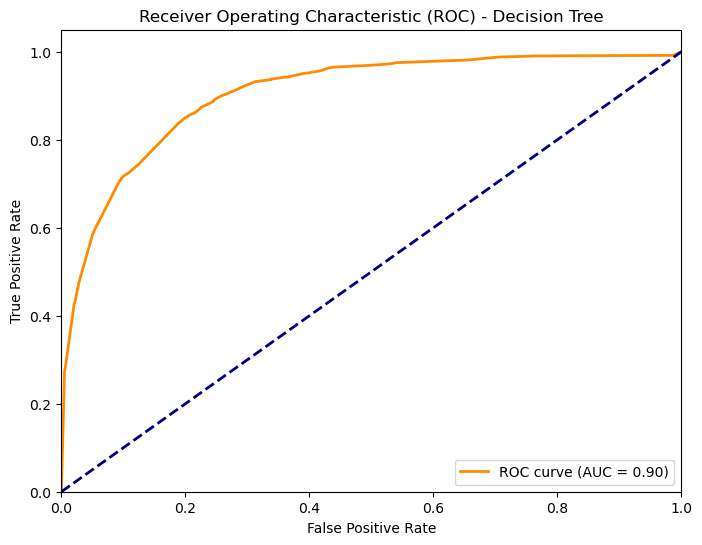

Plotting Decision Tree (Top 3 levels only)...


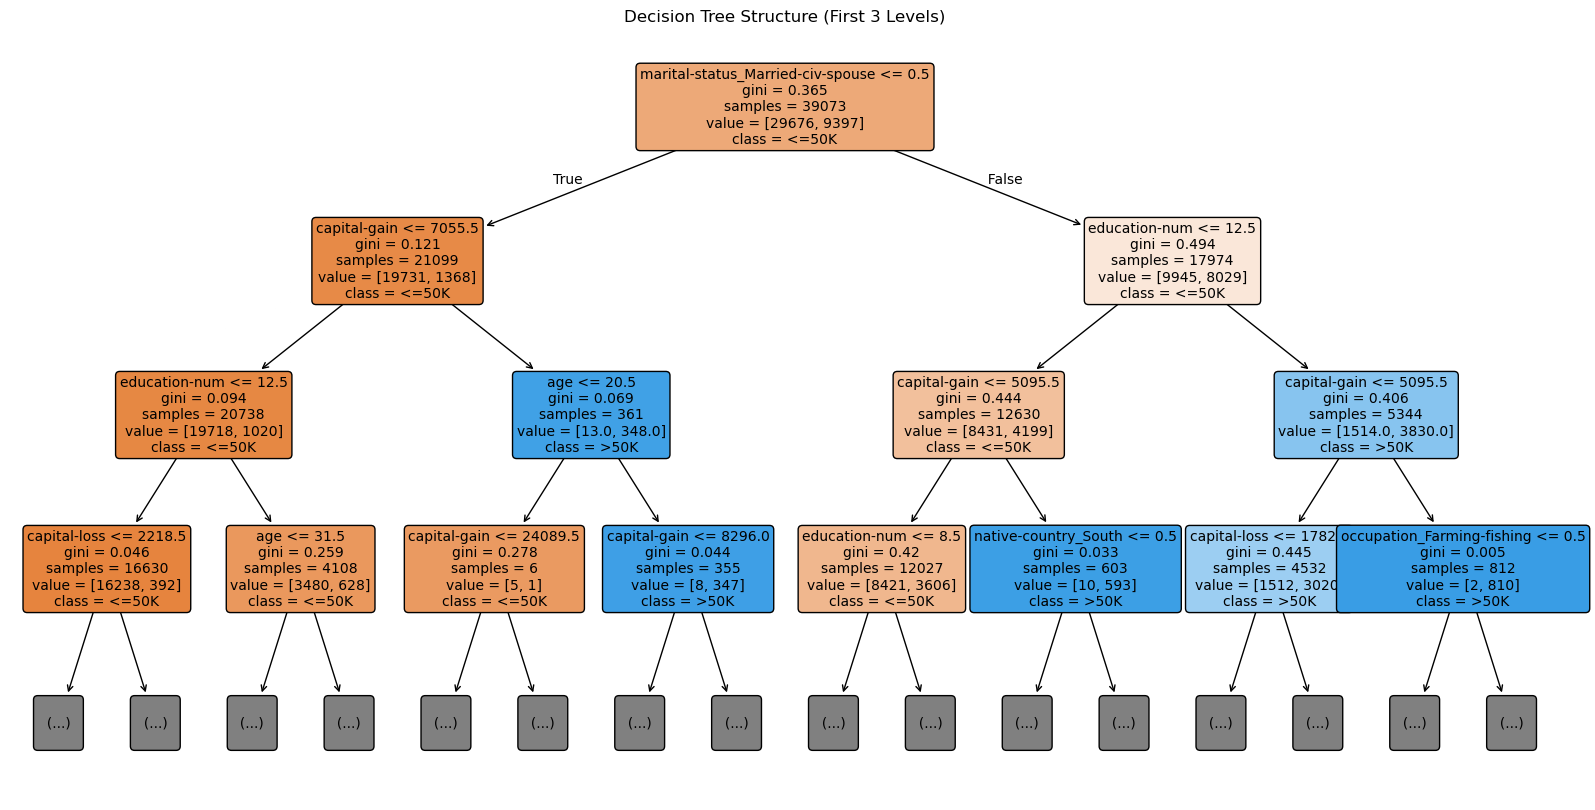

In [3]:
from sklearn.tree import DecisionTreeClassifier

# Initialize
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10) 
# Restricting max_depth usually helps generalization

# Train
dt_model.fit(X_train_processed, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test_processed)

# Evaluate
print("=== Decision Tree Performance ===")
acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)
f1_sc=f1_score(y_test, y_pred_dt)

print(f"Accuracy:  {acc_dt:.4f}")
print(f"Precision: {prec_dt:.4f}")
print(f"Recall:    {rec_dt:.4f}")
print(f"f1 Score:  {f1_sc:.4f}")


# Get probability predictions
y_probs_tuned = dt_model.predict_proba(X_test_processed)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_tuned)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree')
plt.legend(loc="lower right")
plt.show()


plt.rcParams['figure.figsize'] = [12, 6]

#DECISION TREE VISUALIZATION

print("Plotting Decision Tree (Top 3 levels only)...")
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model, 
    max_depth=3,              
    feature_names=feature_names, 
    class_names=['<=50K', '>50K'], 
    filled=True,              
    rounded=True, 
    fontsize=10
)
plt.title("Decision Tree Structure (First 3 Levels)")
plt.show()


# #Random Forests & Ensembles:

# #Bagging (Bootstrap Aggregation):

Bagging is an ensemble technique where multiple models (usually of the same type) are trained on different subsets of the training data. These subsets are created by sampling with replacement. The final prediction is an average (regression) or majority vote (classification) of all models.

# #Why Random Forests reduce overfitting:
A single decision tree has high variance (it changes a lot with small data changes). A Random Forest averages many deep decision trees.

# -->Row Sampling: Each tree sees different data (bootstrapping).

# -->Feature Sampling: 

At each split, the tree can only choose from a random subset of features.
This decorrelates the trees, ensuring they make different errors. Averaging these errors cancels out the noise, resulting in lower variance and better generalization.

# -->Feature Importance:
In tree-based models, we can calculate importance by tracking how much each feature decreases the weighted impurity (Gini or Entropy) across all trees. Features used at the top of the trees contribute more to the decision process.

# #Implementation of RANDOM-FOREST:

=== Random Forest Performance ===
Accuracy:  0.8637
Precision: 0.7649
Recall:    0.6039
f1 Score:  0.6750
AUC Score: 0.9080


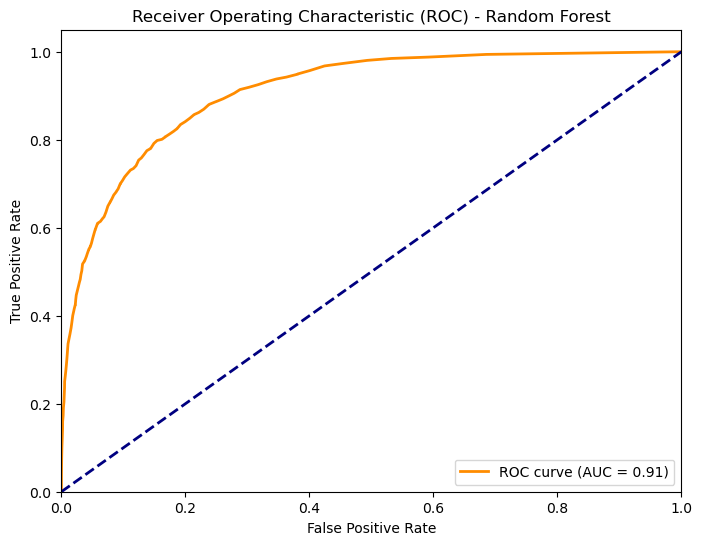

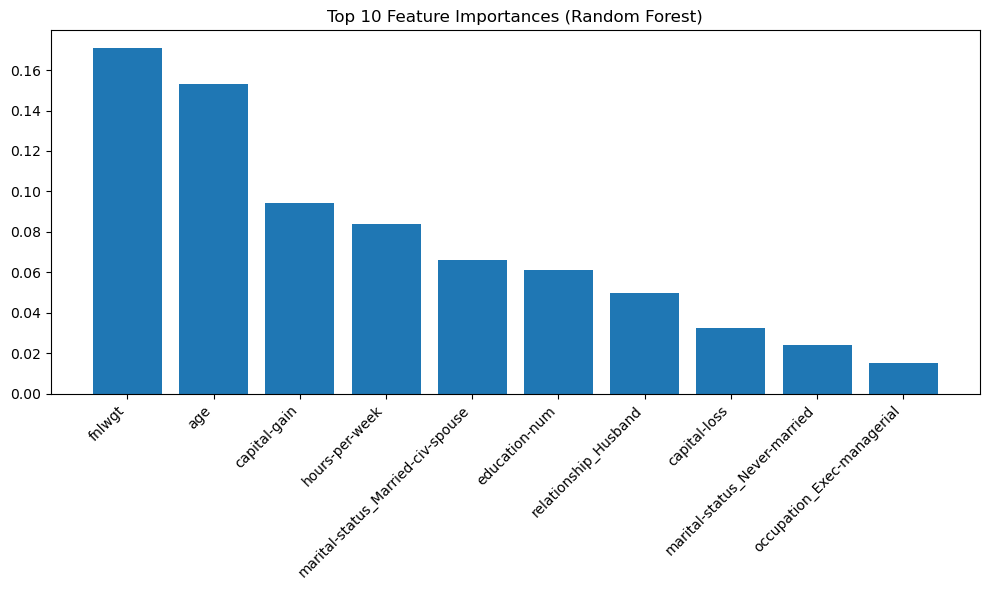

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Initialize
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train
rf_model.fit(X_train_processed, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_processed)

# Evaluate
print("=== Random Forest Performance ===")
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_sc=f1_score(y_test, y_pred_dt)

print(f"Accuracy:  {acc_dt:.4f}")
print(f"Precision: {prec_dt:.4f}")
print(f"Recall:    {rec_dt:.4f}")
print(f"f1 Score:  {f1_sc:.4f}")


# Get probability predictions
y_probs_tuned = rf_model.predict_proba(X_test_processed)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_tuned)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 10 features:
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # Gradient Boosting:

# #Boosting vs Bagging:

# -->Bagging (Parallel): 
Trains models independently on random subsets. Goal is to reduce variance (overfitting).

# -->Boosting (Sequential): 
Trains models sequentially. Each new model attempts to correct the errors made by the previous models. Goal is to reduce bias (underfitting) and variance.

# -->Sequential Learning:
In Gradient Boosting, the first model predicts the target. The second model predicts the residual (error) of the first model. The third predicts the residual of the combined previous models, and so on.

# -->Learning Rate:
This scales the contribution of each tree. A lower learning rate means each tree makes a smaller correction, requiring more trees (n_estimators) to reach the solution but generally resulting in a more robust model that generalizes better.



# #Implementation of Gradient Boosting:

=== XGBoost Performance ===
Accuracy:  0.8637
Precision: 0.7649
Recall:    0.6039
f1 Score:  0.6750
AUC Score: 0.9305


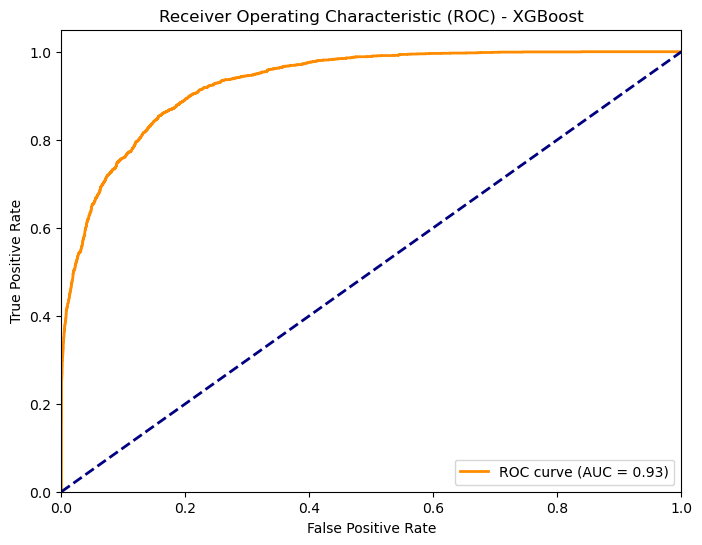

Plotting XGBoost Feature Importance...


<Figure size 1000x600 with 0 Axes>

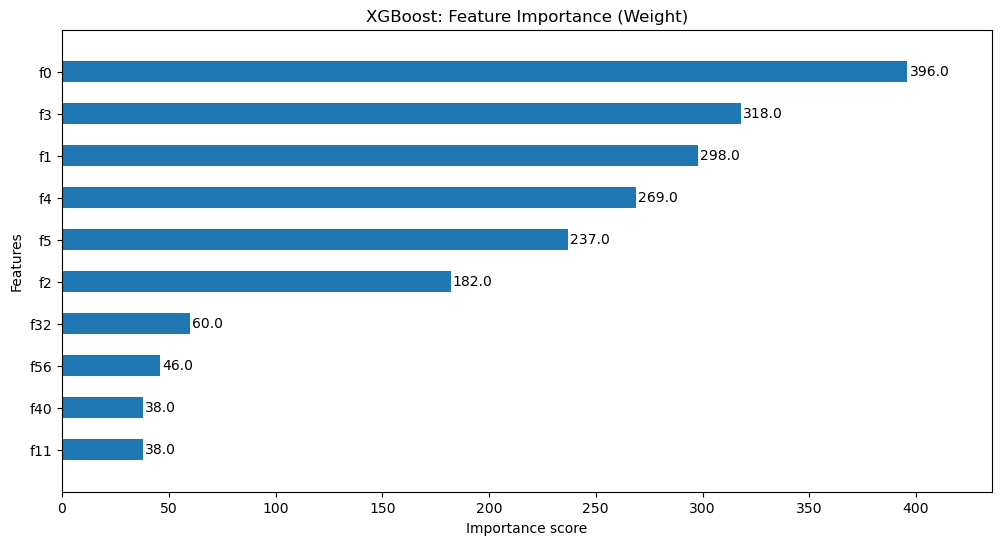

In [5]:


import xgboost as xgb

# Initialize
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    eval_metric='logloss',
    random_state=42
)

# Train
xgb_model.fit(X_train_processed, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_processed)

# Evaluate
print("=== XGBoost Performance ===")
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_sc=f1_score(y_test, y_pred_dt)

print(f"Accuracy:  {acc_dt:.4f}")
print(f"Precision: {prec_dt:.4f}")
print(f"Recall:    {rec_dt:.4f}")
print(f"f1 Score:  {f1_sc:.4f}")


# Get probability predictions
y_probs_tuned = xgb_model.predict_proba(X_test_processed)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_tuned)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.show()

print("Plotting XGBoost Feature Importance...")

plt.figure(figsize=(10, 6))

xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight', height=0.5, grid=False)
plt.title("XGBoost: Feature Importance (Weight)")
plt.show()

# #Hyperparameter Tuning:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Initialize Search
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=10, 
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
print("Tuning XGBoost...")
random_search.fit(X_train_processed, y_train)

# Best Model
best_xgb = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate Best Model
y_pred_tuned = best_xgb.predict(X_test_processed)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned XGBoost Accuracy: {acc_tuned:.4f}")

Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Tuned XGBoost Accuracy: 0.8780


# #Model Interpretability (SHAP):

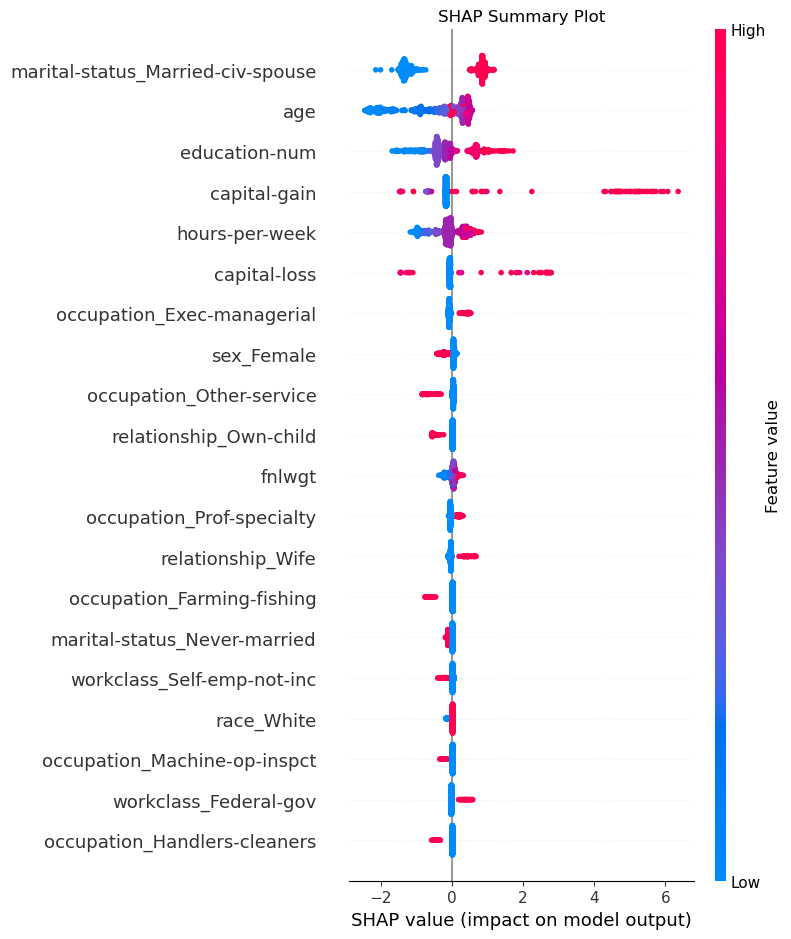

In [ ]:
"""
import sys
# This installs xgboost/shap into the currently active kernel (Base)
!{sys.executable} -m pip install shap
"""

import shap

# Initialize SHAP Explainer (Using the TreeExplainer for XGBoost)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_processed[:1000])

# Summary Plot
plt.figure()
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test_processed[:1000], feature_names=feature_names)

# #Final Comparison:

             Model  Accuracy  Precision    Recall
0    Decision Tree  0.863650   0.764934  0.603930
1    Random Forest  0.859556   0.730191  0.635808
2   XGBoost (Base)  0.880233   0.799145  0.653275
3  XGBoost (Tuned)  0.877981   0.786236  0.658515


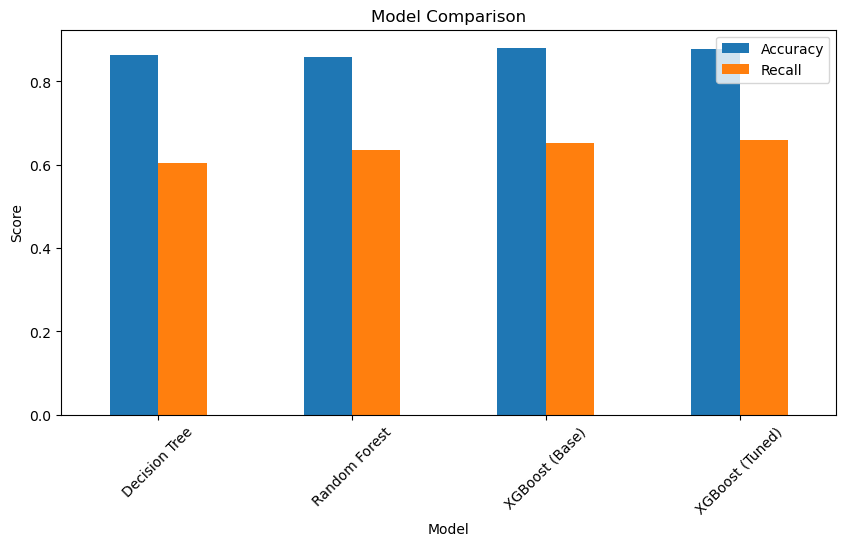

In [14]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost (Base)', 'XGBoost (Tuned)'],
    'Accuracy': [acc_dt, acc_rf, acc_xgb, acc_tuned],
    'Precision': [prec_dt, prec_rf, prec_xgb, precision_score(y_test, y_pred_tuned)],
    'Recall': [rec_dt, rec_rf, rec_xgb, recall_score(y_test, y_pred_tuned)]
})

print(results)

# Visual Comparison
results.set_index('Model')[['Accuracy', 'Recall']].plot(kind='bar', figsize=(10, 5))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

### Final Model Comparison

| Model | Accuracy | Precision | Recall | Remarks |
| :--- | :--- | :--- | :--- | :--- |
| **Decision Tree** | 0.863650 | 0.764934  | 0.603930 | Baseline model; high interpretability but prone to overfitting. |
| **Random Forest** | 0.859556 | 0.730191| 0.635808 | Improved generalization due to Bagging (lower variance). |
| **XGBoost (Base)** | 0.880233  | 0.799145 | 0.653275 | Gradient Boosting (Sequential); generally higher accuracy. |
| **XGBoost (Tuned)** | 0.877981 | 0.786236 | 0.658515 | Best performance after Hyperparameter Tuning. |